<a href="https://colab.research.google.com/github/gongx030/etv2_pioneer/blob/master/GM12878_VAE_on_merged_scATAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compare the performance of VAE trained on full ATAC-seq and merged scATAC-seq
by Wuming Gong


This notebook investigates the performance of VAE model trained on full ATAC-seq data and merged scATAC-seq data.  We will use the scATAC to measure the performance. Since the profiles of bulk ATAC-seq and merged scATAC-seq look very simiar, it is expected to see similar VAE perfomrnace.  Both bulk RNA-seq and scATAC-seq are GM12878.

In [1]:
start_time0 <- Sys.time()

In [2]:
options(max.print=1000)

## Install and load R packages

In [3]:
install.packages('BiocManager')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [4]:
required_packages <- c(
    'devtools', 'BiocManager', 
    'reshape2', 'ggplot2', 'umap', 'ggrepel', 'fields',
    'BSgenome.Hsapiens.UCSC.hg19', 'TxDb.Hsapiens.UCSC.hg19.knownGene'
)

In [5]:
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}

Bioconductor version 3.12 (BiocManager 1.30.10), R 4.0.3 (2020-10-10)

Installing package(s) 'BiocVersion', 'reshape2', 'umap', 'ggrepel', 'fields',
  'BSgenome.Hsapiens.UCSC.hg19', 'TxDb.Hsapiens.UCSC.hg19.knownGene'

also installing the dependencies ‘formatR’, ‘MatrixGenerics’, ‘DelayedArray’, ‘lambda.r’, ‘futile.options’, ‘SummarizedExperiment’, ‘futile.logger’, ‘snow’, ‘bit’, ‘GenomeInfoDbData’, ‘XML’, ‘zlibbioc’, ‘GenomicAlignments’, ‘bitops’, ‘BiocParallel’, ‘Rhtslib’, ‘bit64’, ‘plogr’, ‘BiocFileCache’, ‘rappdirs’, ‘RcppEigen’, ‘dotCall64’, ‘BiocGenerics’, ‘S4Vectors’, ‘IRanges’, ‘GenomeInfoDb’, ‘GenomicRanges’, ‘Biostrings’, ‘rtracklayer’, ‘matrixStats’, ‘XVector’, ‘Rsamtools’, ‘RSQLite’, ‘RCurl’, ‘biomaRt’, ‘Biobase’, ‘plyr’, ‘reticulate’, ‘RSpectra’, ‘spam’, ‘maps’, ‘BSgenome’, ‘GenomicFeatures’, ‘AnnotationDbi’


Old packages: 'pbdZMQ', 'backports', 'gitcreds', 'htmlwidgets', 'jsonlite',
  'ps', 'tinytex', 'usethis', 'foreign', 'nlme'



In [6]:
library(devtools)

Loading required package: usethis



### Install the `seatac` package

In [30]:
install_github('gongx030/seatac', auth_token = '1ec80806b12d3ff2416826d69f13b74adb5188ae', force = TRUE, quiet = FALSE, ref = 'iss1')
reload(pkgload::inst("seatac"))
library(seatac)


✔  checking for file ‘/tmp/Rtmp4gmXvm/remotes4073a4a35/gongx030-seatac-bdb64414a8fea42eac8479880de229363e6cac3f/DESCRIPTION’ (588ms)
─  preparing ‘seatac’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘seatac_0.3.20.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Reloading attached seatac


Attaching package: ‘seatac’


The following object is masked from ‘package:tfdatasets’:

    fit


The following object is masked from ‘package:stats’:

    predict




In [8]:
library(dplyr)
library(tidyr)
library(reshape2) # melt
library(ggplot2)
library(gplots)
library(SummarizedExperiment)
library(BSgenome.Hsapiens.UCSC.hg19)
library(matrixStats)
library(rtracklayer)
library(Matrix)
library(fields)
library(TxDb.Hsapiens.UCSC.hg19.knownGene)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:S4Vectors’:

    expand



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘gplots’


The following object is masked from ‘package:IRanges’:

    

## Load merged scATAC-seq BAM file for GM12878

In [9]:
remote_bam_file <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20201123a/GM.bam'
system(sprintf('wget -x -c -nH %s', remote_bam_file))
bam_file <- gsub('https://s3.msi.umn.edu/', './', remote_bam_file)

In [10]:
blacklist_file <- 'https://s3.msi.umn.edu/gongx030/datasets/datasets=blacklists_version=20190827a/hg19.blacklist.bed.gz'
blacklist <- blacklist_file %>%
  url() %>%
  gzcon() %>%
  readLines() %>%
  textConnection() %>%
  read.table(header = TRUE, sep = '\t')
blacklist <- GRanges(seqnames = blacklist[, 1], range = IRanges(blacklist[, 2], blacklist[, 3]))

In [11]:
peak_size <- 250 # the ATAC-seq peaks
window_size <- 1000 # the vplot window size
remote_bed_file <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_summits.bed'
gr <- read.table(remote_bed_file, header = FALSE, sep = '\t')
gr <- GRanges(seqnames = gr[, 1], range = IRanges(gr[, 2], gr[, 3]))
gr <- gr %>% resize(width = window_size, fix = 'center')
gr <- gr[!gr %over% blacklist]
gr <- gr[!seqnames(gr) %in% c('chrM', 'chrY')]
gr

GRanges object with 80992 ranges and 0 metadata columns:
          seqnames              ranges strand
             <Rle>           <IRanges>  <Rle>
      [1]     chr1       756220-757219      *
      [2]     chr1       762531-763530      *
      [3]     chr1       804802-805801      *
      [4]     chr1       894196-895195      *
      [5]     chr1       895520-896519      *
      ...      ...                 ...    ...
  [80988]     chrX 154695790-154696789      *
  [80989]     chrX 154740068-154741067      *
  [80990]     chrX 154806977-154807976      *
  [80991]     chrX 154841974-154842973      *
  [80992]     chrX 154861846-154862845      *
  -------
  seqinfo: 25 sequences from an unspecified genome; no seqlengths

## Read NucleoATAC results on full GM12878 data
These results will be used as the `ground truth` nucleosomes

In [12]:
nucleoatac_file <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_20170314b.nucleoatac_signal.smooth.bw'
system(sprintf('wget -x -c -nH %s', nucleoatac_file))
local_nucleoatac_file <- gsub('https://s3.msi.umn.edu/', './', nucleoatac_file)

In [13]:
cvg_full <- rtracklayer::import(local_nucleoatac_file, granges(gr), format = 'BigWig', as = 'RleList')

## Load the BAM files for GM12878 scATAC-seq data

In [14]:
dataset <- 'dataset=Buenrostro_version=20201123a'
public_metadata_file <- sprintf('https://s3.msi.umn.edu/gongx030/datasets/%s/metadata.tsv', dataset)
d <- read.table(public_metadata_file, header = TRUE, sep = '\t')
d <- d %>%
	mutate(cell_type = gsub('.+?: singles-(.+?)-.+; .+', '\\1', experiment_title)) %>%
	filter(cell_type %in% c('GM')) %>%
	mutate(remote_bam_file = sprintf('https://s3.msi.umn.edu/gongx030/datasets/%s/%s.bam', dataset, run)) %>%
  mutate(local_bam_file = gsub('https://s3.msi.umn.edu/', './', remote_bam_file)) %>%
  mutate(remote_seatac_file = gsub('.bam', '.seatac.bw', remote_bam_file)) %>%
	mutate(local_seatac_file = gsub('https://s3.msi.umn.edu/', './', remote_seatac_file)) %>%
  mutate(local_sc_seatac_file = gsub('.bam', 'sc.seatac.bw', local_bam_file)) 

In [15]:
for (i in 1:20){
  system(sprintf('wget -x -c -nH %s', d[i, 'remote_bam_file']))
  system(sprintf('wget -x -c -nH %s', d[i, 'remote_seatac_file']))
}

There might be some cells which SeATAC prediction is not available.

In [16]:
message(sprintf('# available scATAC BAM files: %d/%d', sum(d[, 'local_bam_file'] %>% file.exists()), nrow(d)))
message(sprintf('# available SeATAC prediction files: %d/%d', sum(d[, 'local_seatac_file'] %>% file.exists()), nrow(d)))

# available scATAC BAM files: 20/480

# available SeATAC prediction files: 20/480



In [17]:
d <- d %>%
  filter(file.exists(d$local_bam_file) & file.exists(d$local_seatac_file))

## Examine the V-plot of the merged scATAC-seq

indexing bam files: ./gongx030/datasets/dataset=Buenrostro_version=20201123a/GM.bam

Warning message:
“  Using providerVersion() on a BSgenome object is deprecated. Please use
  'metadata(x)$genome' instead.”
read_bam | reading ./gongx030/datasets/dataset=Buenrostro_version=20201123a/GM.bam

Warning message:
“  Using providerVersion() on a BSgenome object is deprecated. Please use
  'metadata(x)$genome' instead.”
dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



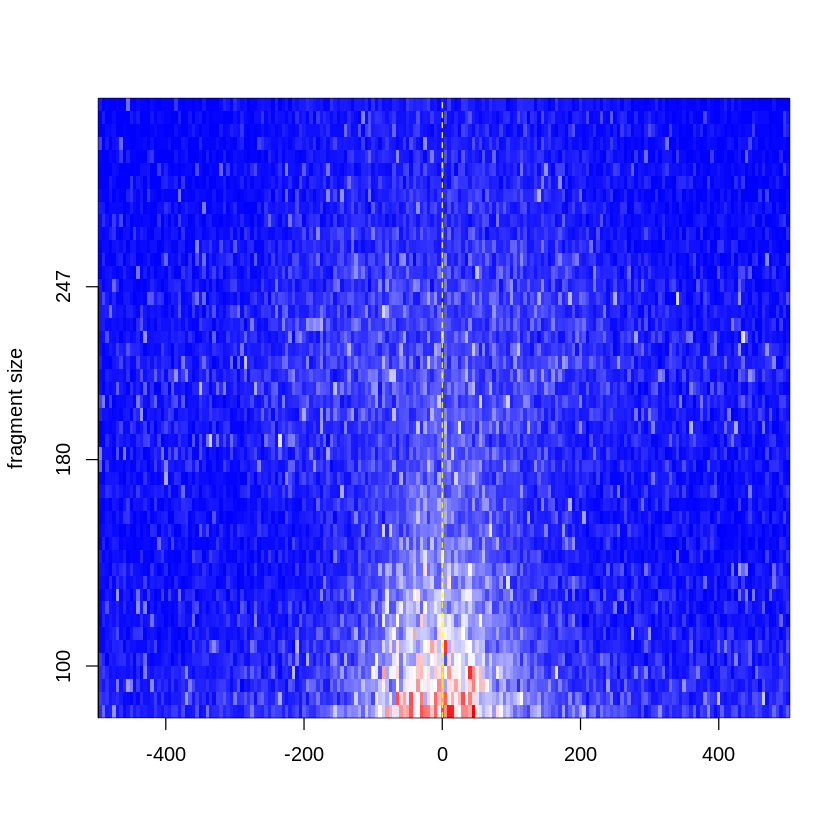

In [18]:
gr[1:5000] %>% 
  read_vplot(bam_file,  genome = BSgenome.Hsapiens.UCSC.hg19) %>% 
  vplot()

## Prepare the blocks for training VAE

In [19]:
block_size <- 640L
step_size <- 20L
blocks <- gr %>% 
	slidingWindows(width = block_size, step = step_size) %>%
	unlist()
fragment_size_range <- c(80, 320)

In [20]:
message(sprintf('there are %d %d-bp blocks', length(blocks), block_size))

there are 1538848 640-bp blocks



Count how many paired-end reads which fragment size is between 80 and 320 bp.

In [21]:
n <- blocks %>% count_reads(bam_file, BSgenome.Hsapiens.UCSC.hg19)

Warning message:
“  Using providerVersion() on a BSgenome object is deprecated. Please use
  'metadata(x)$genome' instead.”
read_bam | reading ./gongx030/datasets/dataset=Buenrostro_version=20201123a/GM.bam



In [22]:
min_reads <- 15L
has_enough_reads <- n >= min_reads
message(sprintf('there are %d blocks that have more than %d qualified paired-end reads.', sum(has_enough_reads), min_reads))

there are 480388 blocks that have more than 15 qualified paired-end reads.



In [23]:
blocks <- blocks[has_enough_reads]

## Read V-plot for selected blocks

In [24]:
n_blocks <- 50000L
set.seed(1)
train_index <- sample(1:length(blocks), n_blocks)
x <- blocks[train_index] %>% read_vplot(bam_file,  genome = BSgenome.Hsapiens.UCSC.hg19) 

Warning message:
“  Using providerVersion() on a BSgenome object is deprecated. Please use
  'metadata(x)$genome' instead.”
read_bam | reading ./gongx030/datasets/dataset=Buenrostro_version=20201123a/GM.bam

Warning message:
“  Using providerVersion() on a BSgenome object is deprecated. Please use
  'metadata(x)$genome' instead.”


In [25]:
x

class: Vplots 
dim: 50000 6144 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(0):
colnames: NULL
colData names(0):
## fragment_size_range:80,320
## fragment_size_interval:5
## n_intervals:48
## bin_size:5
## window_size:640
## n_bins_per_window:128

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



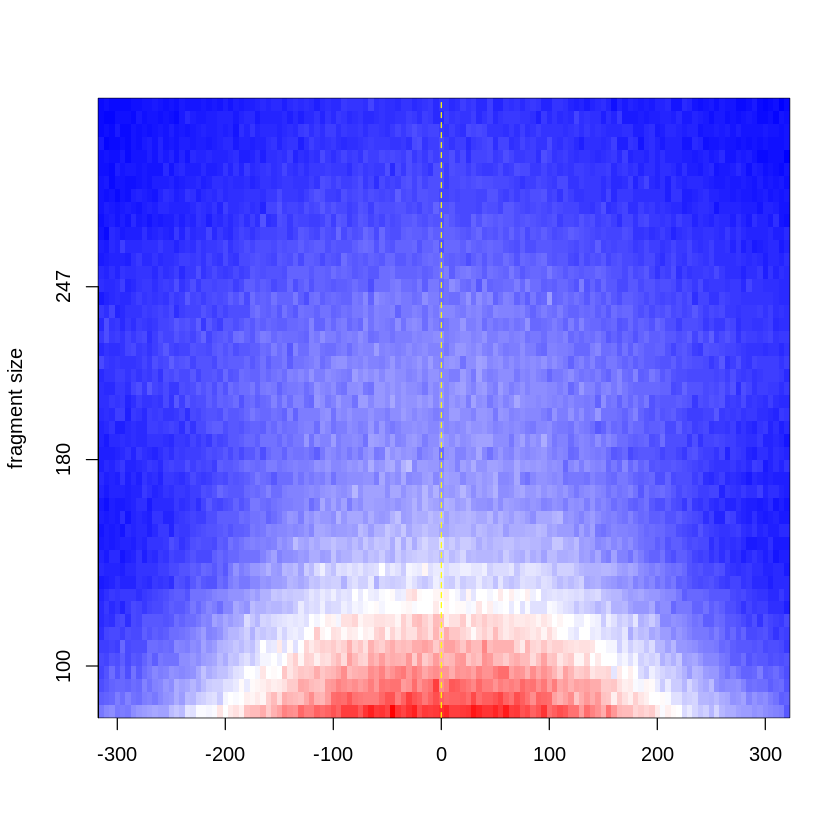

In [31]:
vplot(x)

## Train a VAE model

In [32]:
filters0 <- 128L
latent_dim <- 10L
model <- new('VaeModel', model = VaeModel(block_size = block_size, latent_dim = latent_dim, n_intervals = x@n_intervals, filters0 = filters0))

In [33]:
dx <- prepare_data(model, x) %>%
  tensor_slices_dataset()

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



In [34]:
epochs <- 100L
model <- model %>% fit(dx, epochs = epochs, batch_size = 256L, test_size = 0.15)

epoch=     1/   100 | train_recon_loss=  135.0407387 | train_kl_loss=    0.1926129 | train_loss=  135.2333517 | test_recon_loss=  133.4872197

epoch=     2/   100 | train_recon_loss=  133.2005917 | train_kl_loss=    0.0053819 | train_loss=  133.2059741 | test_recon_loss=  132.1294698

epoch=     3/   100 | train_recon_loss=  133.1416116 | train_kl_loss=    0.0046370 | train_loss=  133.1462489 | test_recon_loss=  132.9949430

epoch=     4/   100 | train_recon_loss=  132.5688283 | train_kl_loss=    0.0044443 | train_loss=  132.5732725 | test_recon_loss=  132.5131399

epoch=     5/   100 | train_recon_loss=  132.9089358 | train_kl_loss=    0.0049206 | train_loss=  132.9138566 | test_recon_loss=  132.3176188

epoch=     6/   100 | train_recon_loss=  132.6278411 | train_kl_loss=    0.0041669 | train_loss=  132.6320085 | test_recon_loss=  133.1496595

epoch=     7/   100 | train_recon_loss=  132.5629191 | train_kl_loss=    0.0046701 | train_loss=  132.5675892 | test_recon_loss=  132.1599747


## Predicting the nucleosome profiles on scATAC-seq data

In [35]:
for (i in 1:nrow(d)){
  xi <- gr %>% read_vplot(d[i, 'local_bam_file'],  genome = BSgenome.Hsapiens.UCSC.hg19)
  model %>% 
    predict(xi, batch_size = 256) %>%
    rtracklayer::export.bw(d[i, 'local_sc_seatac_file'])
}

Streaming output truncated to the last 5000 lines.
predict | batch=    93/   217

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

predict | batch=    94/   217

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

predict | batch=    95/   217

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

predict | batch=    96/   217

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

predict | batch=    97/   217

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

predict | batch=    98/   217

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

predict | batch=    99/   217

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

predict | batch=   100/   217

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

predict | bat

## Import nucleosome coveraged predicted by models based on bulk ATAC-seq and merged scATAC-seq

In [36]:
cvg_bulk <- lapply(1:nrow(d), function(i) rtracklayer::import(d[i, 'local_seatac_file'], granges(gr), format = 'BigWig', as = 'RleList'))

In [37]:
cvg_sc <- lapply(1:nrow(d), function(i) rtracklayer::import(d[i, 'local_sc_seatac_file'], granges(gr), format = 'BigWig', as = 'RleList'))

In [38]:
blocks <- gr %>% 
	slidingWindows(width = block_size, step = step_size) %>%
	unlist()

In [39]:
blocks

GRanges object with 1538848 ranges and 0 metadata columns:
            seqnames              ranges strand
               <Rle>           <IRanges>  <Rle>
        [1]     chr1       756220-756859      *
        [2]     chr1       756240-756879      *
        [3]     chr1       756260-756899      *
        [4]     chr1       756280-756919      *
        [5]     chr1       756300-756939      *
        ...      ...                 ...    ...
  [1538844]     chrX 154862126-154862765      *
  [1538845]     chrX 154862146-154862785      *
  [1538846]     chrX 154862166-154862805      *
  [1538847]     chrX 154862186-154862825      *
  [1538848]     chrX 154862206-154862845      *
  -------
  seqinfo: 25 sequences from an unspecified genome; no seqlengths

## Find the blocks that are not empty in either of two models

In [40]:
blocks_valid <- lapply(1:nrow(d), function(i){
  n_bulk <- cvg_bulk[[i]][blocks] %>% sum()
  n_sc <- cvg_sc[[i]][blocks] %>% sum()
  valid <- n_sc > 0 & n_bulk > 0
  if (any(valid))
    blocks[valid]
})

In [41]:
lapply(blocks_valid, length)

[[1]]
[1] 5294

[[2]]
[1] 55066

[[3]]
[1] 16833

[[4]]
[1] 8727

[[5]]
[1] 50186

[[6]]
[1] 6715

[[7]]
[1] 574

[[8]]
[1] 8807

[[9]]
[1] 683

[[10]]
[1] 9981

[[11]]
[1] 9768

[[12]]
[1] 1026

[[13]]
[1] 17077

[[14]]
[1] 9999

[[15]]
[1] 406

[[16]]
[1] 35846

[[17]]
[1] 24580

[[18]]
[1] 7480

[[19]]
[1] 28088

[[20]]
[1] 28118

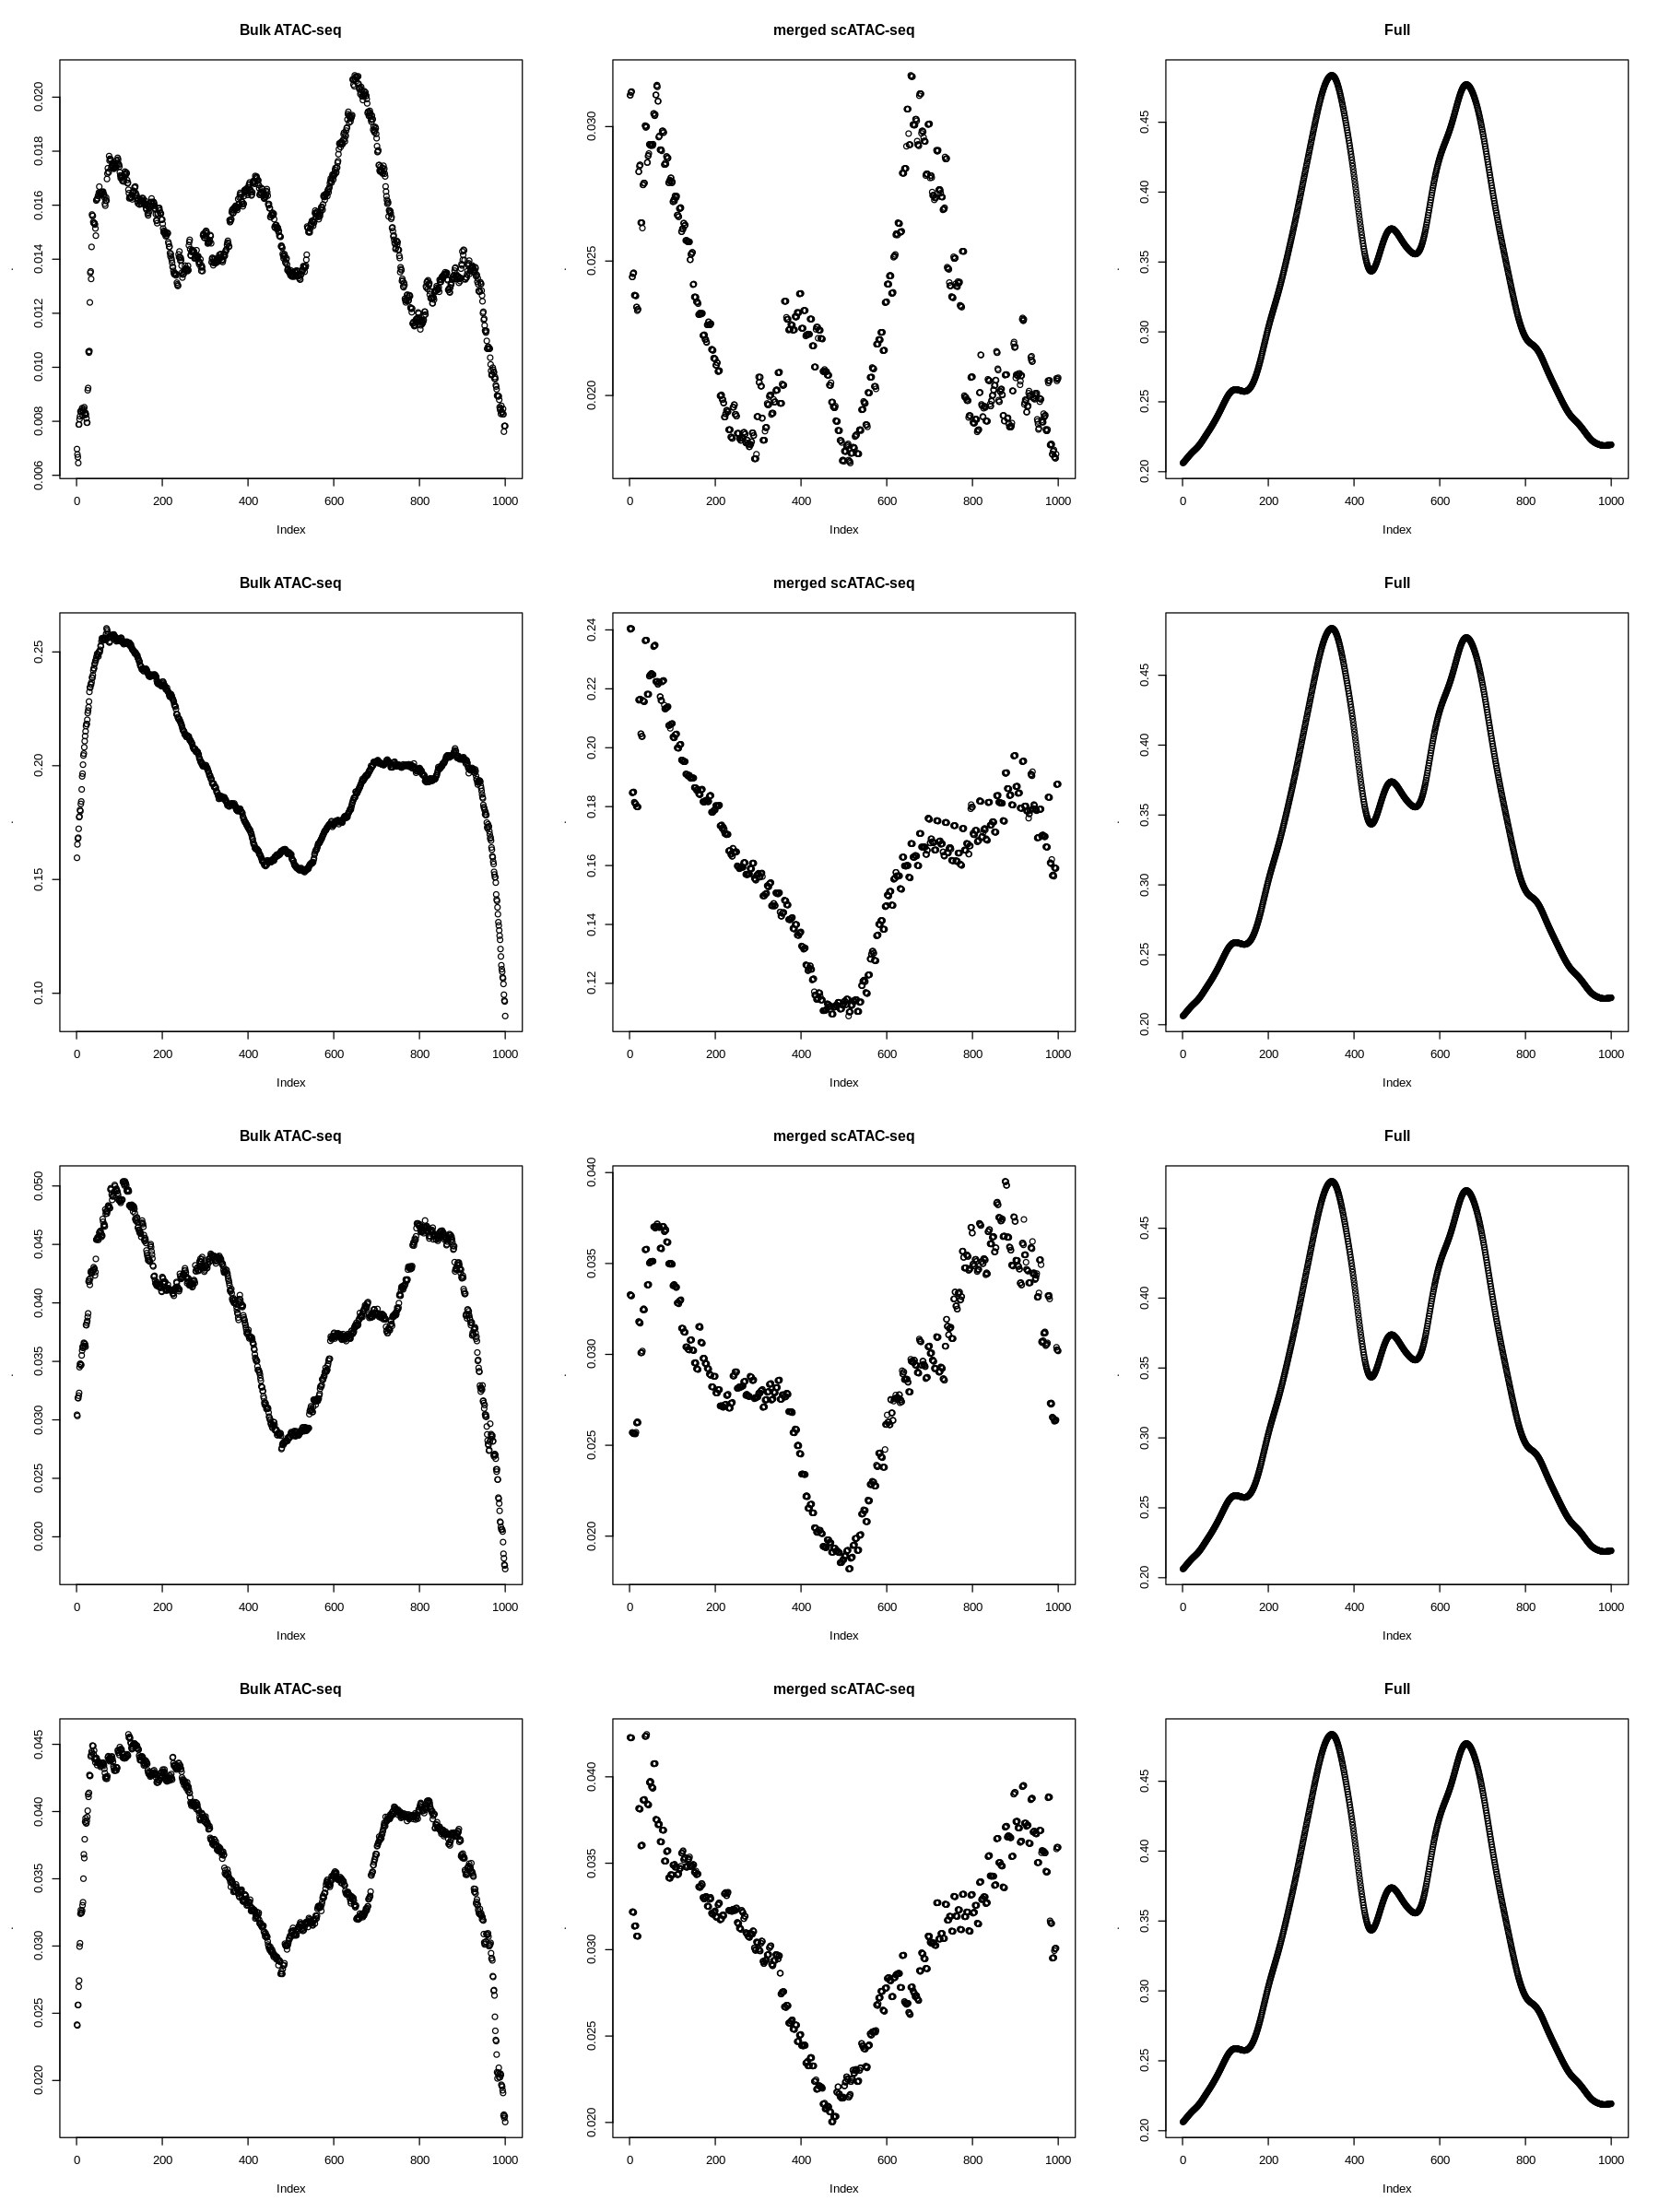

In [42]:
options(repr.plot.width = 15, repr.plot.height = 20)
par(mfrow = c(4, 3))
for (i in 1:4){
  cvg_bulk[[i]][gr[1:5000]] %>% as.matrix() %>% colMeans() %>% plot(main = 'Bulk ATAC-seq')
  cvg_sc[[i]][gr[1:5000]] %>% as.matrix() %>% colMeans() %>% plot(main = 'merged scATAC-seq')
  cvg_full[gr[1:5000]] %>% as.matrix() %>% colMeans() %>% plot(main = 'Full')
}

It appears that the nucleosome profiles predicted by the model trained on the merge scATAC-seq data are not smooth. It is possible that even though the aggregated counts of scATAC-seq look similar to that of bulk ATAC-seq, the aggregated V-plot may have some difference.  Need to investigate the exact different.  At least for now, we cannot used the merged scATAC-seq data to train the VAE model.

## SessionInfo

In [ ]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] TxDb.Hsapiens.UCSC.hg19.knownGene_3.2.2
 [2] GenomicFeatures_1.42.1                 
 [3] AnnotationDbi_1.52.0                   
 [4] fields_11.6                            
 [5] spam_2.5-1                             
 [6] dotC

In [ ]:
Sys.time() - start_time0

Time difference of 1.382798 hours